In [28]:
import matplotlib.pyplot as plt

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np

path = 'https://stepik.org/media/attachments/lesson/779914/fen_train.csv'
train = pd.read_csv(path)

In [43]:
test = pd.read_csv('https://stepik.org/media/attachments/lesson/779914/fen_test.csv')

In [45]:
df_test_melt = test.melt(
    id_vars="signal_id",
    value_vars=[f"p{i}" for i in range(1, 128 + 1)],
    var_name="orders",
    value_name="value",
).merge(test[["signal_id"]], on="signal_id", how="left")


### plot

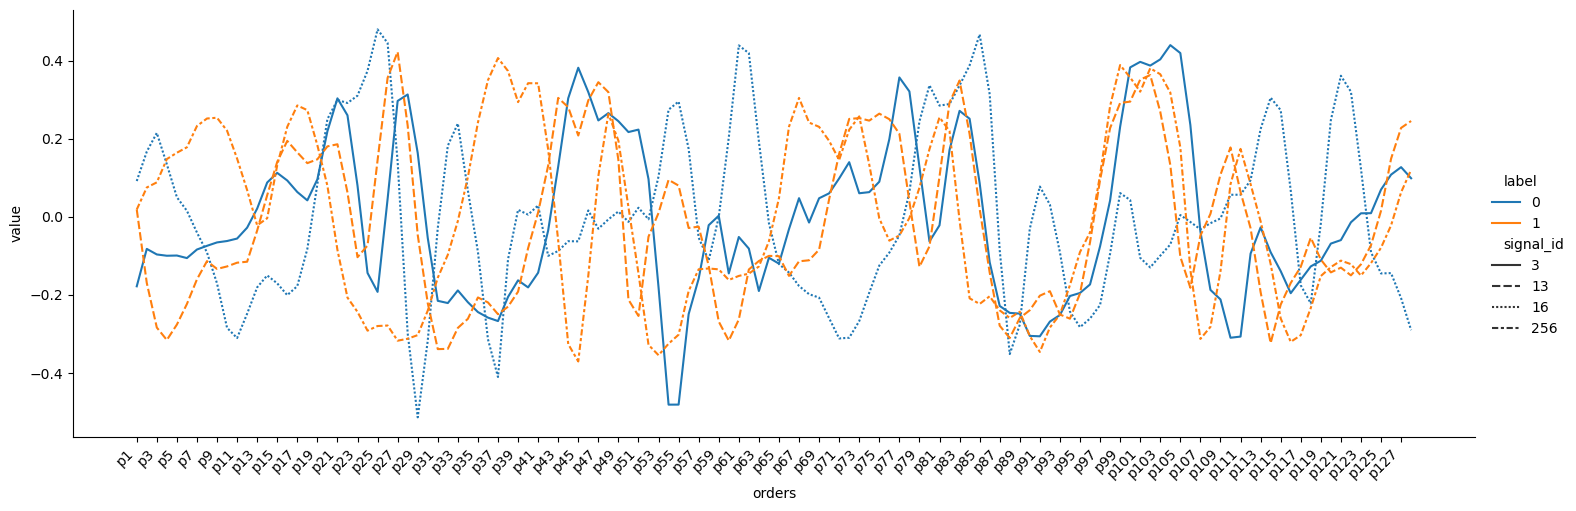

In [2]:
# Переводим датасет в long формат
df_melt = train.melt(
    id_vars="signal_id",
    value_vars=[f"p{i}" for i in range(1, 128 + 1)],
    var_name="orders",
    value_name="value",
).merge(train[["signal_id", "label"]], on="signal_id", how="left")

# Отбираем несколько примеров разных классов
tmp = df_melt[df_melt.signal_id.isin([3, 13, 16, 256])]

# Строим графику
sns.relplot(
    data=tmp,
    x="orders",
    y="value",
    hue="label",
    style="signal_id",
    kind="line",
    aspect=3,
).set_xticklabels(rotation=45, horizontalalignment="right", step=2);

In [3]:
true_indexes = train[train.label == 1].signal_id
false_indexes = train[train.label == 0].signal_id

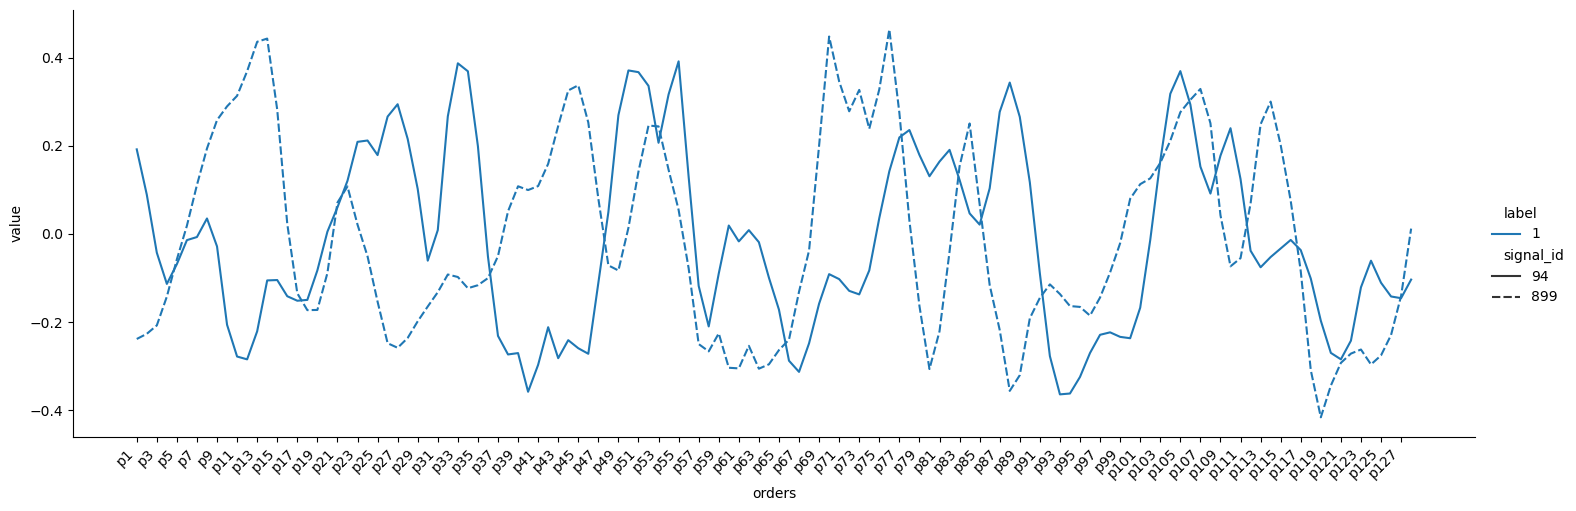

In [4]:
# Отбираем несколько примеров разных классов
tmp = df_melt[df_melt.signal_id.isin(true_indexes.sample(2))]

# tmp = df_melt[df_melt.signal_id.isin(false_indexes.sample(2))]

# Строим графику
sns.relplot(
    data=tmp,
    x="orders",
    y="value",
    hue="label",
    style="signal_id",
    kind="line",
    aspect=3,
).set_xticklabels(rotation=45, horizontalalignment="right", step=2);

### add feats

In [48]:
df_melt['diff'] = df_melt.groupby('signal_id')['value'].diff()
# df_melt['diff2'] = df_melt.groupby('signal_id')['value'].diff(periods=2)
# df_melt['diff4'] = df_melt.groupby('signal_id')['value'].diff(periods=4)
# df_melt['diff8'] = df_melt.groupby('signal_id')['value'].diff(periods=8)

df = df_melt.groupby('signal_id').agg(
    diff_std = ('diff', 'std'),
    # diff2_std = ('diff2', 'std'),
    # diff_mean = ('diff', 'mean'),
    # diff_mean2 = ('diff2', 'mean'),
    diff_0 = ('diff', lambda x: (np.abs(x) < 0.05).sum()),
    label = ('label', lambda x: x.iloc[0])
)

In [50]:
df_test_melt['diff'] = df_test_melt.groupby('signal_id')['value'].diff()

df_test = df_test_melt.groupby('signal_id').agg(
    diff_std = ('diff', 'std'),
    diff_0 = ('diff', lambda x: (np.abs(x) < 0.05).sum()),
)

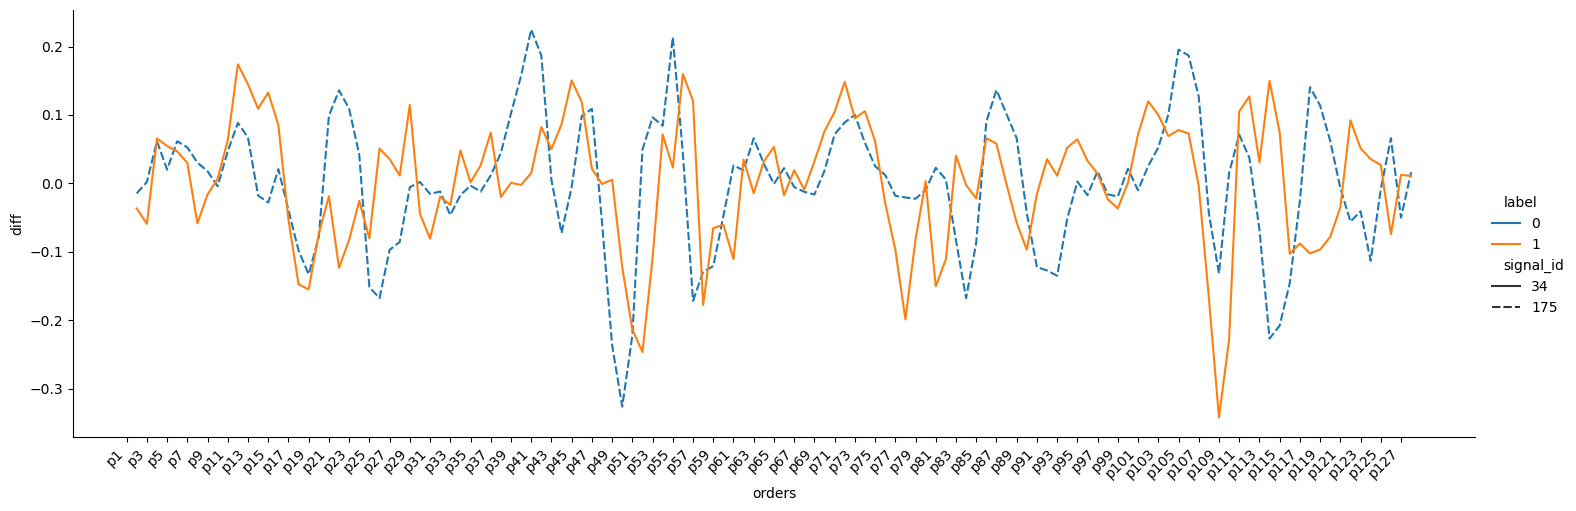

In [6]:
# Отбираем несколько примеров разных классов
tmp = df_melt[df_melt.signal_id.isin(true_indexes.sample(1))]

tmp2 = df_melt[df_melt.signal_id.isin(false_indexes.sample(1))]

# Строим графику
sns.relplot(
    data=pd.concat([tmp, tmp2]),
    x="orders",
    y="diff",
    hue="label",
    style="signal_id",
    kind="line",
    aspect=3,
).set_xticklabels(rotation=45, horizontalalignment="right", step=2);

In [ ]:
# sns.pairplot(
#     df,
#     vars=[i for i in df.columns if i != 'label'],
#     corner=False,
#     hue="label",
# );

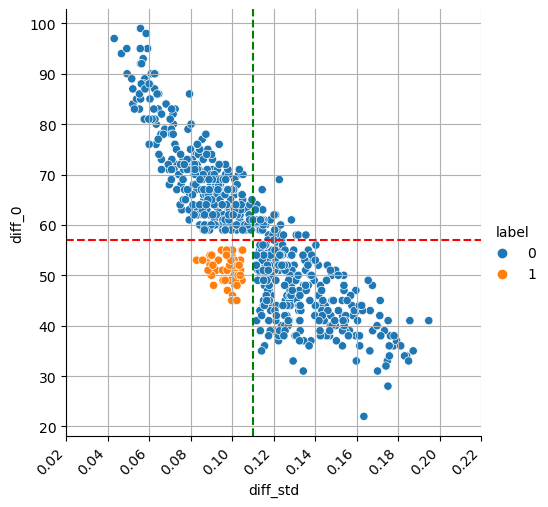

In [34]:
g = sns.relplot(
    data=df, x="diff_std", y="diff_0",  hue='label'
    # aspect=2,
    # height=3,

);
g.set_xticklabels(rotation=45, horizontalalignment="right");
plt.axhline(y=57, color='r', linestyle='--')
plt.axvline(x=0.11, color='g', linestyle='--')
plt.grid()

In [38]:
df['ans'] = ((df['diff_0'] < 57) & (df['diff_std'] < 0.11)).astype(int)

In [42]:
(df.label == df.ans).mean()

1.0

In [51]:
df_test['ans'] = ((df_test['diff_0'] < 57) & (df_test['diff_std'] < 0.11)).astype(int)

In [57]:
df_test.reset_index()[['signal_id', 'ans']].rename({'ans':'label'}, axis=1).to_csv('ts_ans.csv', index=False)